# Gaussian Processes

Gaussian Distribution over Functions, instead of variables in Multivariate Gaussian / Univariate Gaussian

### Table of Contents
1. [Covariance Primer](#cov)
2. [Multivariate Gaussian Visualization](#multigaussviz)
2. [Kernel Functions](#kernels)

In [35]:
# Imports
%matplotlib notebook

import sys
import numpy as np
from scipy import spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
from itertools import combinations, permutations
from sklearn.metrics.pairwise import \
    cosine_similarity, \
    linear_kernel, \
    rbf_kernel, \
    laplacian_kernel

sns.set_style('darkgrid')
np.random.seed(42)

---
## Covariance Primer<a id='cov'></a>

A [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) needs to be symmetric positive semi-definite.

### Table of Contents:
1. [Recap]
2. [Symmetric Positive Definiteness]
3. [Equation of Ellipse]
4. [The Principal Axes Theorem]
5. [Eigendecomposition]
6. [Singular Value Decomposition]
7. [Mahalanobis Distance]
8. [$\chi^2$ Distribution]
9. [Important Notes]
10. [Examples]

### Recap

Traditional Covariance Function (Scaled linear kernel):
$$
\sigma_{xy} = \frac{1}{n-1}\mathbf{x}^\top\mathbf{y}
$$

Design / Data Matrix:
$$
\begin{aligned}
\underset{n\times m}{\mathbf{X}} &= \underset{n\,\text{samples}\,\times \,m\,\text{features}}{\begin{bmatrix} x_{11} & x_{12} & \ldots & x_{1m} \\ x_{21} & x_{22} & \ldots & x_{2m} \\ \vdots & \vdots & \ddots & \vdots \\ x_{n1} & x_{n2} & \ldots & x_{nm} \\ \end{bmatrix}}
\end{aligned}
$$

Unit Matrix (Matrix of all ones):
$$
\begin{aligned}
\underset{n\times n}{\mathbf{e}\mathbf{e}^\top} &= \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} \cdot \begin{bmatrix} 1 & 1 & \ldots & 1 \end{bmatrix} \\
&= \underset{n\,\times \,n}{\begin{bmatrix} 1 & 1 & \ldots & 1 \\ 1 & 1 & \ldots & 1 \\ \vdots & \vdots & \ddots & \vdots \\ 1 & 1 & \ldots & 1 \\ \end{bmatrix}}
\end{aligned}
$$

Matrix of Feature / Covariate Means:
$$
\begin{aligned}
\underset{n\times m}{\bar{\mathbf{X}}} &= \frac{1}{n}\cdot\mathbf{e}\mathbf{e}^\top\cdot \underset{n\times m}{\mathbf{X}} \\
&= \underset{n\,\text{duplicates of feature means}\,\times \,m\,\text{features}}{\begin{bmatrix} \bar{x}_{1} & \bar{x}_{2} & \ldots & \bar{x}_{m} \\ \bar{x}_{1} & \bar{x}_{2} & \ldots & \bar{x}_{m} \\ \vdots & \vdots & \ddots & \vdots \\ \bar{x}_{1} & \bar{x}_{2} & \ldots & \bar{x}_{m} \\ \end{bmatrix}}
\end{aligned}
$$

Sample Data ($\frac{1}{n - 1}$) Covariance Matrix:
$$
\begin{aligned}
\underset{m\times m}{\Sigma} &= \frac{1}{n - 1} {(\underset{n\times m}{\mathbf{X}} - \underset{n\times m}{\bar{\mathbf{X}}})}^\top \cdot {(\underset{n\times m}{\mathbf{X}} - \underset{n\times m}{\bar{\mathbf{X}}})} \\
&= \frac{1}{n - 1} \begin{bmatrix} x_{11} - \bar{x}_{1} & x_{21} - \bar{x}_{1} & \ldots & x_{n1} - \bar{x}_{1} \\ x_{12} - \bar{x}_{2} & x_{22} - \bar{x}_{2} & \ldots & x_{n2} - \bar{x}_{2} \\ \vdots & \vdots & \ddots & \vdots \\ x_{1m} - \bar{x}_{m} & x_{2m} - \bar{x}_{m} & \ldots & x_{nm} - \bar{x}_{m} \\ \end{bmatrix} \cdot \begin{bmatrix} x_{11} - \bar{x}_{1} & x_{12} - \bar{x}_{2} & \ldots & x_{1m} - \bar{x}_{m} \\ x_{21} - \bar{x}_{1} & x_{22} - \bar{x}_{2} & \ldots & x_{2m} - \bar{x}_{m} \\ \vdots & \vdots & \ddots & \vdots \\ x_{n1} - \bar{x}_{1} & x_{n2} - \bar{x}_{2} & \ldots & x_{nm} - \bar{x}_{m} \\ \end{bmatrix} \\
&= \frac{1}{n - 1} \begin{bmatrix} 
\sum^{n}_{i = 1} {(x_{i1} - \bar{x}_{1})}{(x_{i1} - \bar{x}_{1})} & \sum^{n}_{i = 1} {(x_{i1} - \bar{x}_{1})}{(x_{i2} - \bar{x}_{2})} & \ldots & \sum^{n}_{i = 1} {(x_{i1} - \bar{x}_{1})}{(x_{im} - \bar{x}_{m})} \\ 
\sum^{n}_{i = 1} {(x_{i2} - \bar{x}_{2})}{(x_{i1} - \bar{x}_{1})} & \sum^{n}_{i = 1} {(x_{i2} - \bar{x}_{2})}{(x_{i2} - \bar{x}_{2})} & \ldots & \sum^{n}_{i = 1} {(x_{i2} - \bar{x}_{2})}{(x_{im} - \bar{x}_{m})} \\ 
\vdots & \vdots & \ddots & \vdots \\ 
\sum^{n}_{i = 1} {(x_{im} - \bar{x}_{m})}{(x_{i1} - \bar{x}_{1})} & \sum^{n}_{i = 1} {(x_{im} - \bar{x}_{m})}{(x_{i2} - \bar{x}_{2})} & \ldots & \sum^{n}_{i = 1} {(x_{im} - \bar{x}_{m})}{(x_{im} - \bar{x}_{m})} \\ \end{bmatrix} \\
&= \begin{bmatrix} 
Var(x_1) & Cov(x_1, x_2) & \ldots & Cov(x_1, x_m) \\ 
Cov(x_2, x_1) & Var(x_2) & \ldots & Cov(x_2, x_m) \\
\vdots & \vdots & \ddots & \vdots \\
Cov(x_m, x_1) & Cov(x_m, x_2) & \ldots & Var(x_m) \\ 
\end{bmatrix}
\end{aligned}
$$

### [Symmetric Positive Definiteness](https://ocw.mit.edu/resources/res-18-009-learn-differential-equations-up-close-with-gilbert-strang-and-cleve-moler-fall-2015/differential-equations-and-linear-algebra/applied-mathematics-and-ata/positive-definite-matrices/)

A $n \times n$ symmetric real matrix $S$ is said to be `positive definite` if $x^\textsf{T} Sx > 0$ for all non-zero $x$ in $\mathbb{R}^n$.

A $n \times n$ Hermitian complex matrix $S$ is said to be `positive definite` if $x^* Sx > 0$ for all non-zero $x$ in $\mathbb{C}^n$.

Positive-definite matrices are:
- Invertible (Hence, all invertible matrix theorem properties apply)
    - Implies that the Precision (Inverse Covariance) matrix will always exist
- Don't need to be symmetric, but symmetric positive definite matrices are nice

Test for Symmetric Positive Definiteness:
1. All eigenvalues $\lambda > 0$
2. All pivots $> 0$
3. All upper-left determinants $> 0$
4. $S$ has the form $S = A^\top A$, when A is invertible (linearly independent columns)
5. Energy Test: $\mathbf{x}^\top S \mathbf{x} > 0\,\forall\, \mathbf{x} \not= 0$

### Equation of Ellipse

Standard Equation for Axis-aligned Ellipse:

$$
\begin{aligned}
\frac{\left(x-h\right)^{2}}{a}+\frac{\left(y-k\right)^{2}}{b}=r^{2} \\
\end{aligned}
$$

Linear Algebra version (Quadratic Form) for Any Ellipse in Cartesian Coordinates:

$$
\begin{aligned}
\begin{bmatrix}
x-h&y-k
\end{bmatrix}
\underbrace{
\begin{bmatrix}
\frac{1}{a}&0\\0&\frac{1}{b}
\end{bmatrix}
}_{\text{Covariance Matrix } \Sigma}
\begin{bmatrix}
x-h\\y-k
\end{bmatrix} &= r^2\\
\mathbf{x}^T\Sigma\mathbf{x} &= r^2 \\
\end{aligned}
$$

### The Principal Axes Theorem
Let $S$ be an $n x n$ symmetric matrix. Then there is an orthogonal change of variable, $x=Py$, that transforms the quadratic form $x^\top Sx$ into a quadratic from $y^\top Dy$ with no cross-product term ($x_1x_2$), where $D$ is a diagonal $nxn$ matrix.

### [Eigendecomposition / Spectral Decomposition / Diagonalization](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Eigendecomposition_of_a_matrix)

[Diagonalization theorem](https://textbooks.math.gatech.edu/ila/diagonalization.html): We say that an $nxn$ matrix $A$ is diagonalizable if there exists an invertible matrix $S$ such that $S^{−1}AS$ is diagonal.

[Orthogonal Matrix](https://en.wikipedia.org/wiki/Orthogonal_matrix): $Q^\top = Q^{-1}$

Let $\Sigma$ be a square $m \times m$ matrix with $m$ linearly independent eigenvectors $q_{i = 1, \ldots, m}$ (E.g. Covariance Matrix $\because \Sigma \in S_{+}^m$), we can find the eigendecomposition of $\Sigma$ by finding:

$$
\begin{aligned}
\underset{m \times m}{\Sigma} &= \underset{m \times m}{Q}\cdot\underset{m \times m}{\Lambda}\cdot\underset{m \times m}{Q^{-1}} \\
&= \underbrace{\begin{bmatrix} \vert & \vert & \ldots & \vert \\ q_1 & q_2 & \ldots & q_m \\ \vert & \vert & \ldots & \vert \end{bmatrix}}_{\text{Orthogonal Matrix}} \cdot \begin{bmatrix} \lambda_i & 0 & \ldots & 0 \\ 0 & \lambda_2 & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \lambda_m \end{bmatrix} \cdot \underbrace{\begin{bmatrix} \vert & \vert & \ldots & \vert \\ q_1 & q_2 & \ldots & q_m \\ \vert & \vert & \ldots & \vert \end{bmatrix}^{-1}}_{\text{Orthogonal Matrix}}
\end{aligned}
$$

### [Singular Value Decomposition (SVD)](https://www.youtube.com/watch?v=mBcLRGuAFUk&t=47s)

$$
\begin{aligned}
\underset{n \times m}{A} &= \underset{n \times m}{U}\cdot\underset{m \times m}{\Sigma}\cdot\underset{m \times n}{V^\top} \\
&= 
\underbrace{\begin{bmatrix} \vert & \vert & \ldots & \vert \\ u_1 & u_2 & \ldots & u_m \\ \vert & \vert & \ldots & \vert \end{bmatrix}}_\text{Rotation} 
\cdot 
\underbrace{\begin{bmatrix} \sigma_i & 0 & \ldots & 0 \\ 0 & \sigma_2 & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \sigma_m \end{bmatrix}}_\text{Stretching} 
\cdot 
\underbrace{\begin{bmatrix} \vert & \vert & \ldots & \vert \\ v_1 & v_2 & \ldots & v_m \\ \vert & \vert & \ldots & \vert \end{bmatrix}^\top}_\text{Rotation}
\end{aligned}
$$

### [Mahalanobis Distance](https://www.machinelearningplus.com/statistics/mahalanobis-distance/)

Mahalonobis distance is the distance between a point and a distribution, instead of physical distance of point to point in euclidean distance.


### [$\mathcal{X}^2$ Distribution]

Relationship 

### Extremely Important Notes for understanding how to visualize the Confidence Ellipses of the Multivariate Gaussian

- Covariance is just an unstandardized version of Correlation

When visualizing ellipsoids of your data modelled by a multivariate gaussian, we can have 2 distinct cases, one when the covariance matrix is diagonal (off-diagonal entries = 0), and one when the covariance matrix is not diagonal:

1. Covariance Matrix that happens to be diagonal:
    - When the off-diagonal entries of the covariance matrix $\Sigma$, AKA covariance $\sigma_{XY} = 0$, it means that the data is axis-aligned.
    - This also suggests that each random variable / feature (modelled by a gaussian) is independent. Though this is not necessarily the case if there's a non-linear relationship because covariance / correlation only cares about linear relationships between random variables that are modelled by gaussians (If 2 random variables $X$, $Y$ are independent, their covariance / correlation is definitely 0, but the reverse is not true because we might have a non-linear relationship $Y = X^2$)


2. Covariance Matrix that happens to not be diagonal:
    - Visualizing the Multivariate Gaussian when the data is not axis-aligned and it's confidence ellipses can come from 2 perspectives, one involving change of basis / eigendecomposition, and another based on linear transformations like rotation matrix / shear matrix 
        1. Change of Basis / Eigendecomposition Perspective
            - However, if the off-diagonal entries are $\not= 0$, we have to first perform an eigendecomposition: $\Sigma = Q\Lambda Q^{-1}$
            - After getting the eigenvectors in $Q$ (eigenbasis) after the eigendecomposition of $\Sigma$, which will form the new basis for an equation of the ellipse that is axis-aligned to the new basis given by the eigenvectors in $Q$, the new covariance matrix $\Lambda$ will be a diagonal covariance matrix with the eigenvalues, the eigenvalues here represent the variance in the directions of the eigenvectors given in the orthogonal basis $Q$
            - [Change of basis for ellipse to get different equations for the same ellipse](http://aix1.uottawa.ca/~jkhoury/quadratic.htm)
            - [Ellipse and Linear Algebra](https://sites.math.washington.edu/~king/coursedir/m308a01/Projects/m308a01-pdf/brown.pdf)
        2. Rotation / Shear Matrix Perspective

### [Example 1](https://sites.math.washington.edu/~king/coursedir/m308a01/Projects/m308a01-pdf/brown.pdf)


$$
\begin{aligned}
5x_1^2-4x_1x_2+5x_2^2&= 1 \\
\begin{bmatrix}
x_1&x_2
\end{bmatrix}
\begin{bmatrix}
5&-2\\-2&5
\end{bmatrix}
\begin{bmatrix}
x_1\\x_2
\end{bmatrix}
=\mathbf{x}^T\Sigma\mathbf{x} &= 1 \\
\end{aligned}
$$
1. Notice here that the off-diagonals of $\Sigma$ are non-zero, meaning that currently, in the standard basis $x_1 = \Big(\begin{aligned}1\\0\end{aligned}\Big), x_2 = \Big(\begin{aligned}0\\1\end{aligned}\Big)$, the features ($x_1, x_2$) of the data in the ellipse is not independent (There is a linear relationship between $x_1$ and $x_2$). We can also see this interaction explicitly via the $x_1x_2$ term in the first equation.

2. $\Sigma$ is Positive Definite by Test 3: $\vert ad - bc \vert = 25 - 4 > 0$ $\therefore \Sigma$ is invertible

Eigendecomposition of $\Sigma$: 
$$
\begin{aligned}
\Sigma &= Q\Lambda Q \\ 
&= 
\begin{bmatrix}-1&1 \\ 1&1\end{bmatrix}
\begin{bmatrix}7&0 \\ 0&3\end{bmatrix}
\begin{bmatrix}-1&1 \\ 1&1\end{bmatrix}
\end{aligned}
$$

Eigenvectors and Eigenvalues of $\Sigma$:

$v_1 = \begin{bmatrix}-1 \\ 1\end{bmatrix}$ and $\lambda_1 = 7$


$v_2 = \begin{bmatrix}1 \\ 1\end{bmatrix}$ and $\lambda_2 = 3$


### [Example 2](http://aix1.uottawa.ca/~jkhoury/quadratic.htm)

In [29]:
np.exp(-0.5 * spatial.distance.cdist([[0], [0.2]], [[0], [0.2]], 'sqeuclidean'))

array([[1.        , 0.98019867],
       [0.98019867, 1.        ]])

In [32]:
np.linalg.eigvals([[1, 0.8], 
                   [0.8, 1]])

array([1.8, 0.2])

---
## Visualizing Multivariate Gaussian<a id='multigaussviz'></a>

In order to under how we'll be sampling from a multivariate gaussian, we'll want to understand how it looks like

---
## Kernel Functions<a id='kernels'></a>

In the machine learning world, we come up with our own kernel functions used to represent the covariance matrix. However, in the realm of statistics, we have things called covariance structures, which are basically the same thing.

In [2]:
def display_kernel_matrix(kernel=linear_kernel):
    """Illustrate covariance matrix and function
    
    Args: 
        kernel (function): A function that takes as its inputs 
                            vectors in the original space and returns the dot 
                            product of the vectors in the feature space is 
                            called a kernel function.
    """
    # Show covariance matrix example from kernel function provided
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    xlim = (-3, 3)
    X = np.expand_dims(np.linspace(*xlim, 25), 1)
    Σ = kernel(X, X)

    # Plot covariance matrix
    im = ax1.imshow(Σ, cmap=cm.YlGnBu)
    cbar = plt.colorbar(
        im, ax=ax1, fraction=0.045, pad=0.05)
    cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
    ax1.set_title('{} \n example of covariance matrix'
                  .format(kernel.__name__))
    ax1.set_xlabel('x', fontsize=13)
    ax1.set_ylabel('x', fontsize=13)
    ticks = list(range(xlim[0], xlim[1]+1))
    ax1.set_xticks(np.linspace(0, len(X)-1, len(ticks)))
    ax1.set_yticks(np.linspace(0, len(X)-1, len(ticks)))
    ax1.set_xticklabels(ticks)
    ax1.set_yticklabels(ticks)
    ax1.grid(False)

    # Show covariance with X=0
    xlim = (-4, 4)
    X = np.expand_dims(np.linspace(*xlim, num=100), 1)
    zero = np.array([[0]])
    Σ0 = kernel(X, zero)
    # Make the plots
    ax2.plot(X[:,0], Σ0[:,0], label='$k(x,0)$')
    ax2.set_xlabel('x', fontsize=13)
    ax2.set_ylabel('covariance', fontsize=13)
    ax2.set_title('{} covariance\n between $x$ and $0$'\
                  .format(kernel.__name__))
    # ax2.set_ylim([0, 1.1])
    ax2.set_xlim(*xlim)
    ax2.legend(loc=1)

    fig.tight_layout()
    plt.show();

In [11]:
def display_multivariate_normal_samples(kernel, 
                                        n=41,
                                        k=5):
    """Sample from the Gaussian process distribution
    
    Args:
        kernel (function): A function that takes as its inputs 
                            vectors in the original space and returns the dot 
                            product of the vectors in the feature space is 
                            called a kernel function.
        n (int): Number of points in each function
        k (int): Number of functions to sample
        
    """
    # Independent variable samples
    X = np.expand_dims(np.linspace(-4, 4, n), 1)
    Σ = kernel(X, X)  # Kernel of data points

    # Draw samples from the prior at our data points.
    # Assume a mean of 0 for simplicity
    ys = np.random.multivariate_normal(mean=np.zeros(n), 
                                       cov=Σ, 
                                       size=k)

    # Plot the sampled functions
    plt.figure(figsize=(6, 4))
    for i in range(k):
        plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
    plt.xlabel('$x$', fontsize=13)
    plt.ylabel('$y = f(x)$', fontsize=13)
    plt.title((
        '{} different function realizations at {} points \n \
        sampled from a Gaussian process with {} kernel'.format(k, n, kernel.__name__)))
    plt.xlim([-4, 4])
    plt.show();

### Exponentiated Quadratic (Radial Basis Function)

<IPython.core.display.Javascript object>


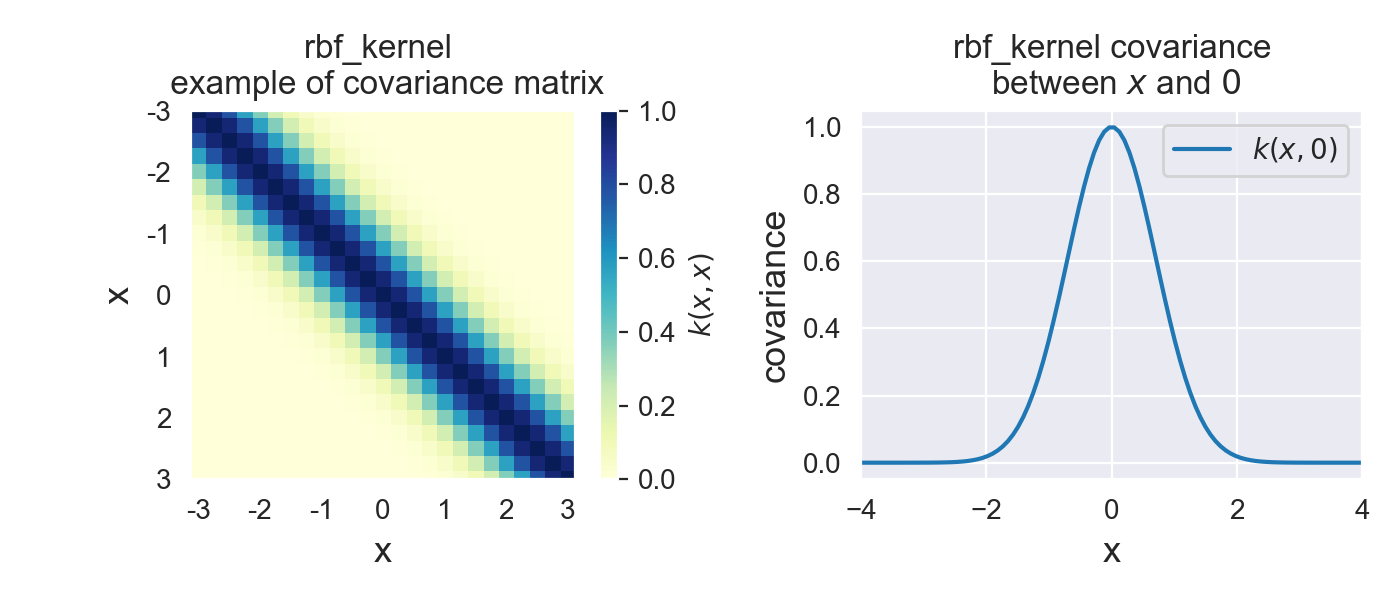

In [21]:
display_kernel_matrix(kernel=rbf_kernel)

<IPython.core.display.Javascript object>


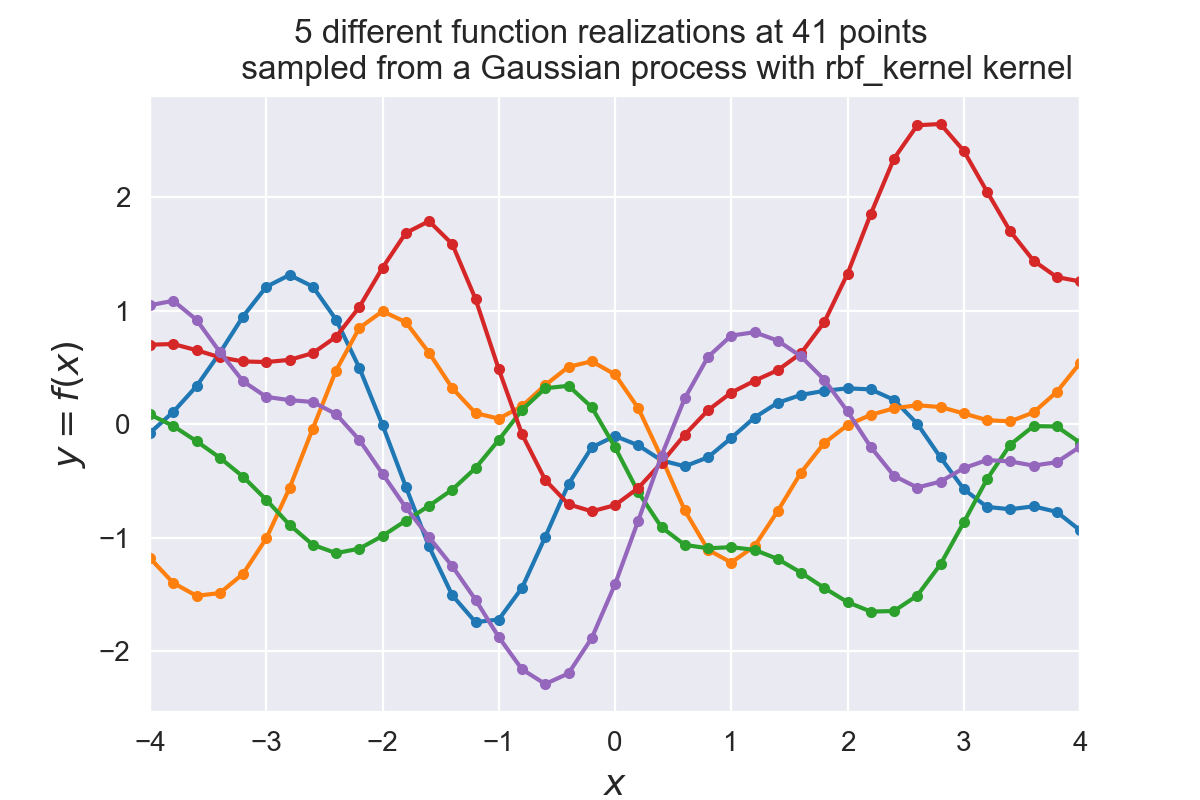

In [22]:
display_multivariate_normal_samples(kernel=rbf_kernel, n=41, k=5)

### Linear

<IPython.core.display.Javascript object>


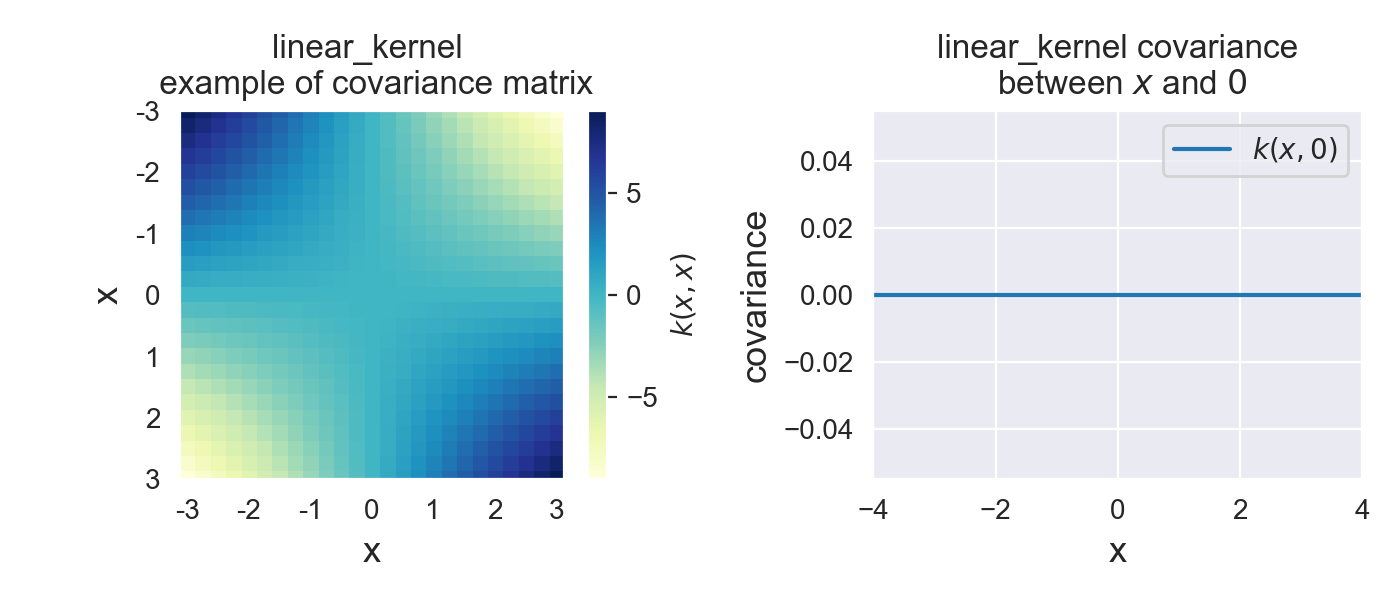

In [23]:
display_kernel_matrix(kernel=linear_kernel)

<IPython.core.display.Javascript object>


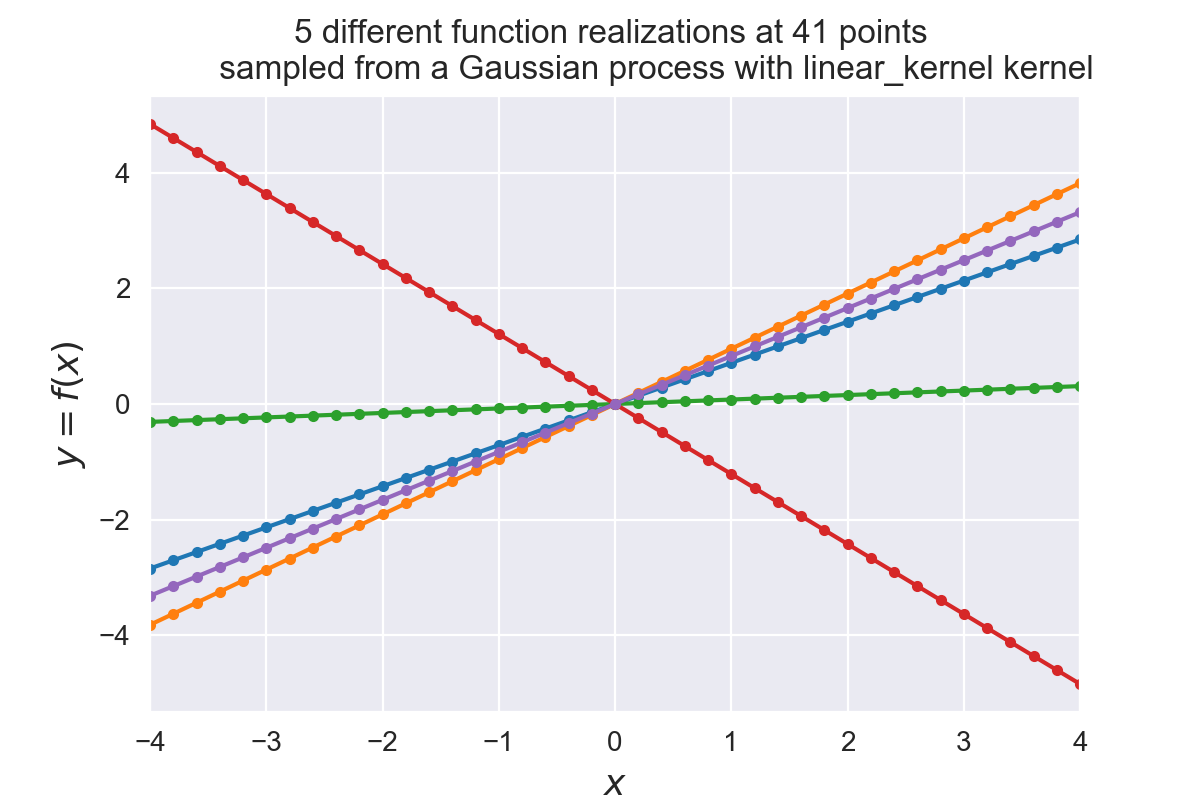

In [14]:
display_multivariate_normal_samples(kernel=linear_kernel, n=41, k=5)

### Cosine Similarity

<IPython.core.display.Javascript object>


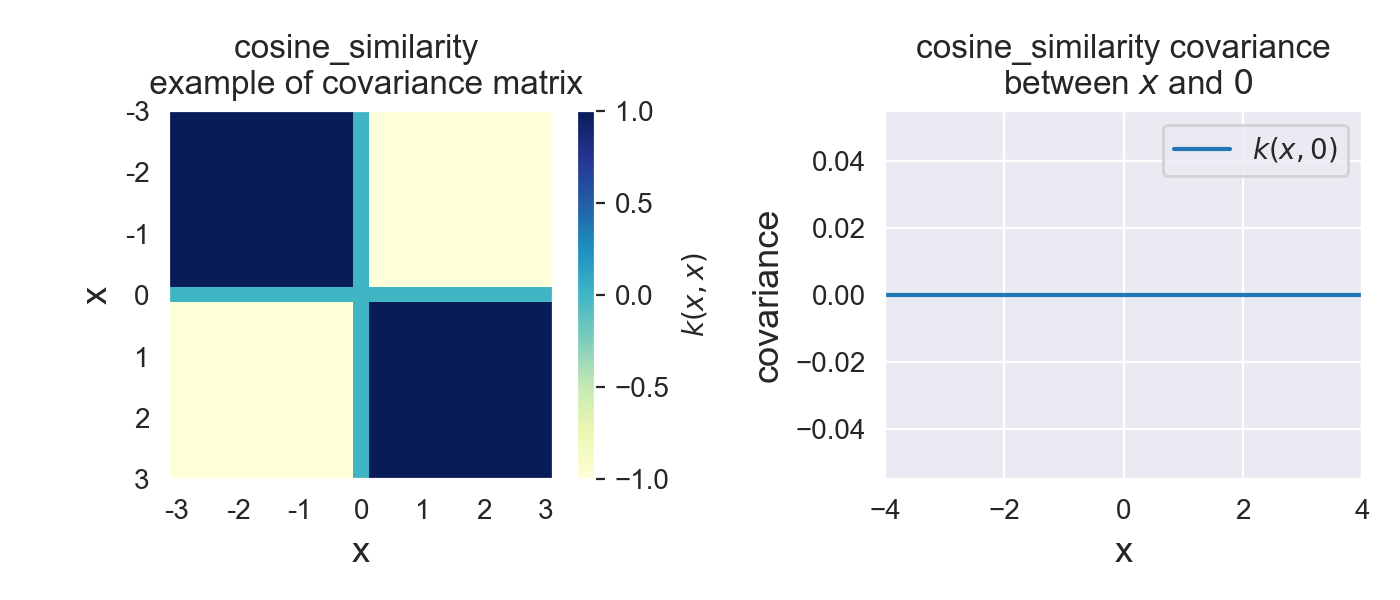

In [24]:
display_kernel_matrix(kernel=cosine_similarity)

<IPython.core.display.Javascript object>


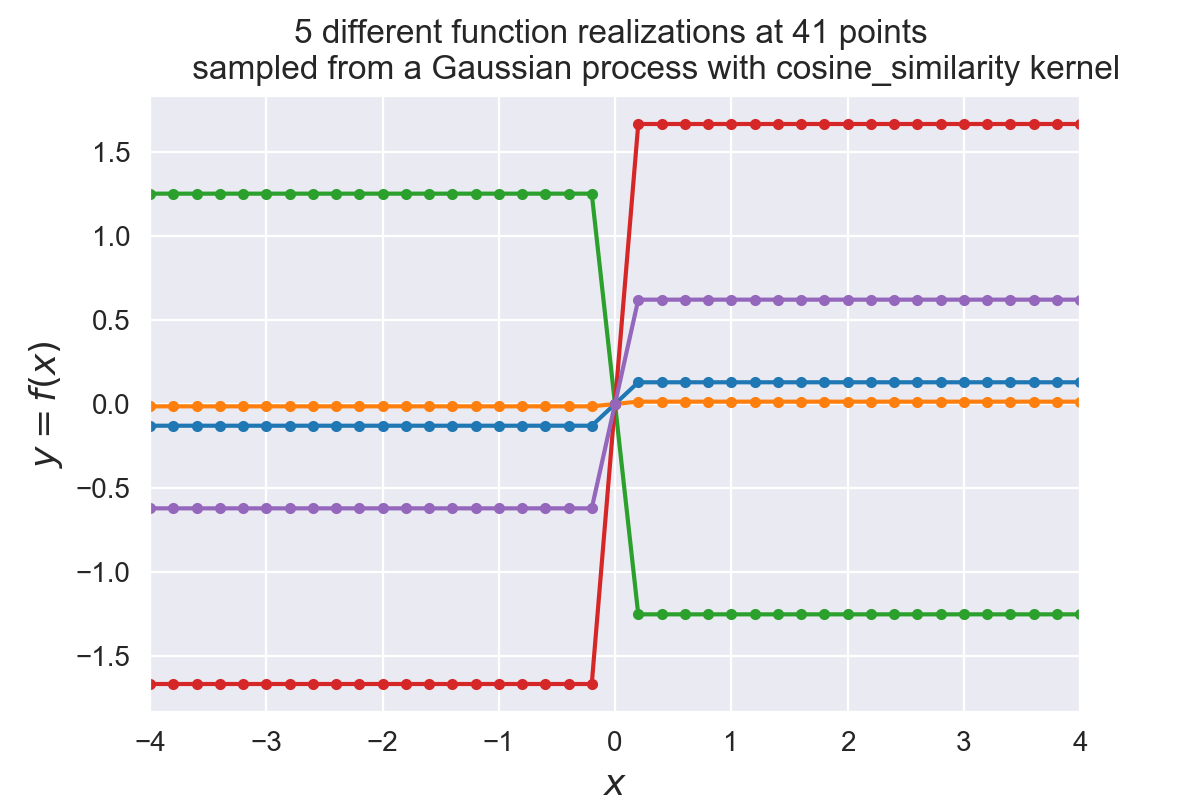

In [16]:
display_multivariate_normal_samples(kernel=cosine_similarity, n=41, k=5)

### Laplacian

<IPython.core.display.Javascript object>


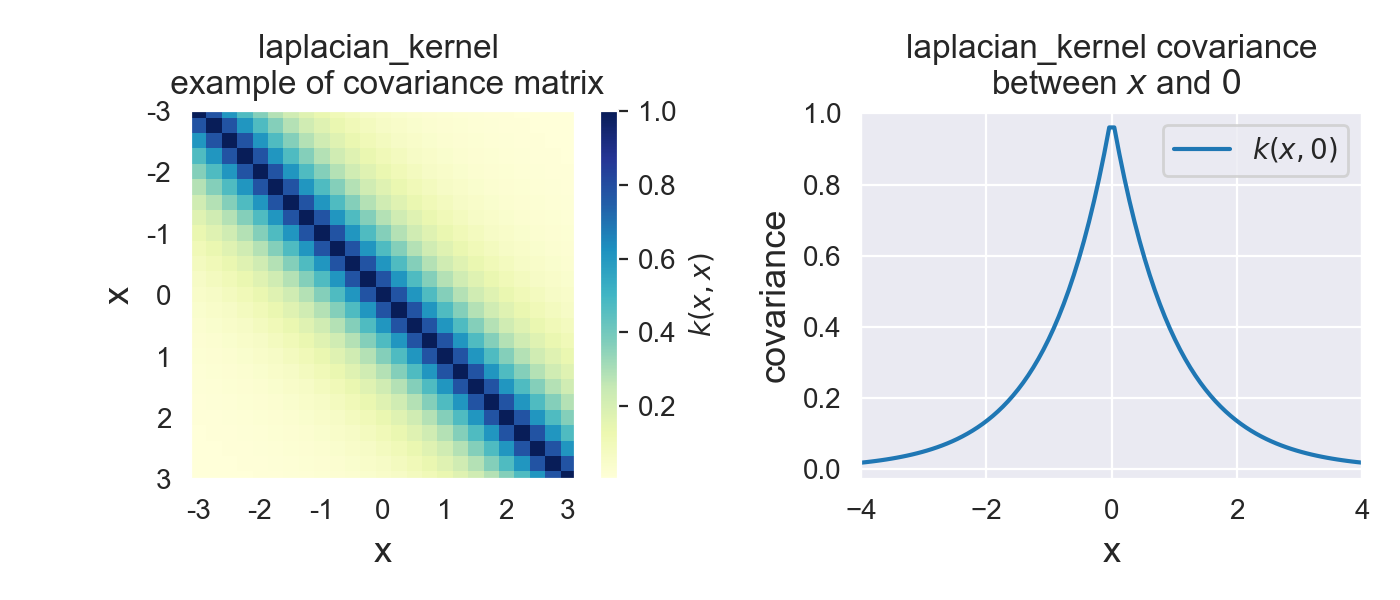

In [25]:
display_kernel_matrix(kernel=laplacian_kernel)

<IPython.core.display.Javascript object>


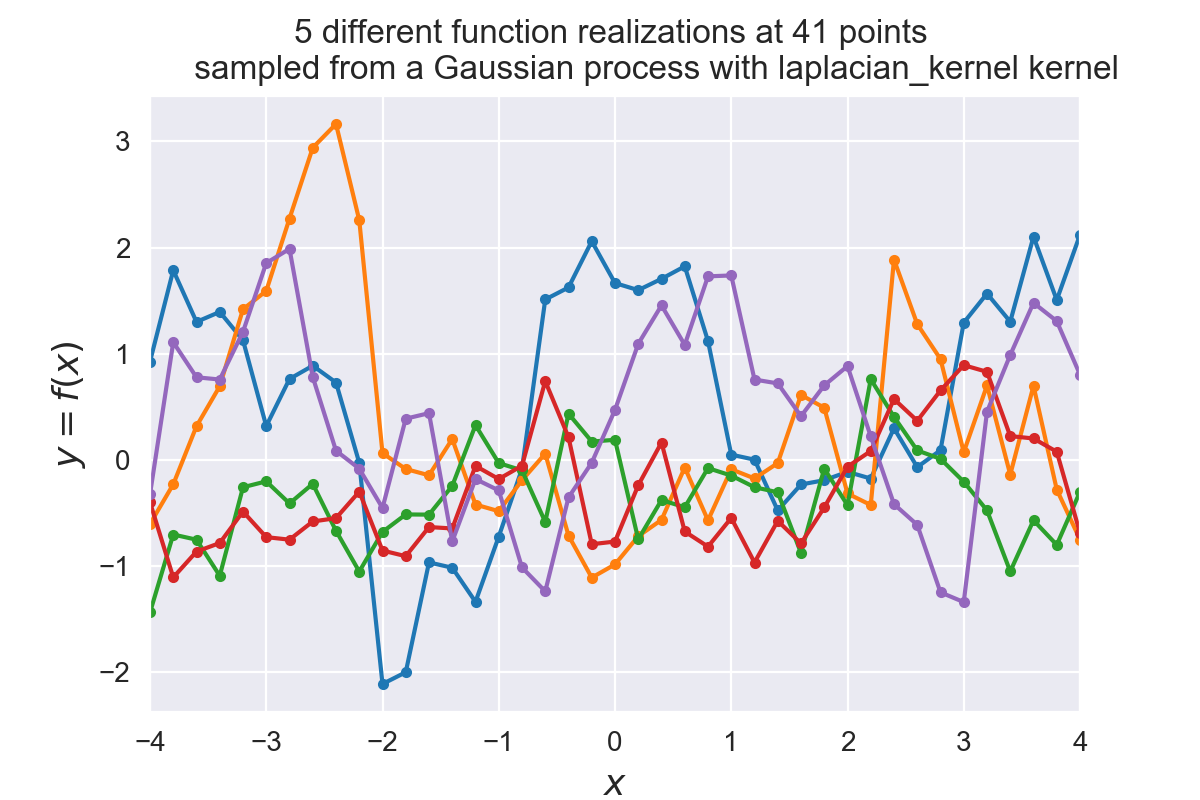

In [26]:
display_multivariate_normal_samples(kernel=laplacian_kernel, n=41, k=5)

### Resources

Statistics:
- [Is there any relationship among cosine similarity, pearson correlation, and z-score?](https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)
- [Why we standardize data to get $z$-score](https://math.stackexchange.com/questions/317114/what-is-the-purpose-of-subtracting-the-mean-from-data-when-standardizing)
- [Understanding the Covariance matrix](https://datascienceplus.com/understanding-the-covariance-matrix/)
- [Covariance Structures](https://www.ibm.com/support/knowledgecenter/en/SSLVMB_sub/statistics_mainhelp_ddita/spss/advanced/covariance_structures.html)
- [The Analytics Factor on Covariance Matrices](https://www.theanalysisfactor.com/covariance-matrices/)
- [Guidelines for Selecting the Covariance Structure in Mixed
Model Analysis ](https://support.sas.com/resources/papers/proceedings/proceedings/sugi30/198-30.pdf)

Machine Learning:
- [Peterroelants' Gaussian Process primer](https://peterroelants.github.io/posts/gaussian-process-tutorial/)
- [Kernel Design](http://gpss.cc/gpss15/talks/KernelDesign.pdf)
- [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)
- [Conditional Multivariate Gaussian Proof](http://fourier.eng.hmc.edu/e161/lectures/gaussianprocess/node7.html)
- [Multivariate Gaussian Distribution](https://www.youtube.com/watch?v=eho8xH3E6mE)
- [How to draw a covariance error ellipse?](https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/)